In [46]:
import numpy as np
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import umap.umap_ as umap
import warnings
%matplotlib inline

warnings.filterwarnings("ignore")

sns.set(style='white', context='notebook', rc={'figure.figsize':(14,10)})

### Extract and clean data

In [47]:
soloq_games = pd.read_csv("../data/soloq/Europe_stats.csv")

soloq_games = soloq_games.dropna()
# delete games with < 15 mins
soloq_games = soloq_games[soloq_games['gameEndedInEarlySurrender'] == False]
# creates a patch column
soloq_games['patch'] = soloq_games.apply(lambda x: str(x['gameVersion'].split('.')[0] + '.' + x['gameVersion'].split('.')[1]), axis=1 )

In [48]:
relevant_cols = [
    "patch", "teamPosition", "championId", "championName", "gameDuration", "win",
    "neutralMinionsKilled", "totalMinionsKilled", "cs_diff_at_15",
    "champExperience", "xp_diff", "xp_diff_per_min", "xp_per_min_3_15",
    "damageDealtToBuildings", "damageDealtToObjectives", "damageDealtToTurrets", "damageSelfMitigated", "magicDamageDealt", "magicDamageDealtToChampions", "magicDamageTaken",
    "physicalDamageDealt", "physicalDamageDealtToChampions", "physicalDamageTaken", "totalDamageDealt", "totalDamageDealtToChampions", "totalDamageShieldedOnTeammates",
    "totalDamageTaken", "totalHeal", "totalHealsOnTeammates", "totalUnitsHealed", "trueDamageDealt", "trueDamageDealtToChampions", "trueDamageTaken",
    "totalTimeCCDealt", "timeCCingOthers", "totalTimeSpentDead", "dmg_per_minute_diff", "dmg_per_minute_diff_15", "kills", "deaths", "assists", "kill_share", "kill_participation",
    "doubleKills", "tripleKills", "quadraKills", "pentaKills", "firstBloodAssist", "firstBloodKill", "killingSprees", "largestKillingSpree", "largestMultiKill",
    "goldEarned", "goldSpent", "gold_share", "gold_earned_per_min", "gold_diff_15", "gold_10k_time",
    "inhibitorKills", "inhibitorTakedowns", "inhibitorsLost", 
    "itemsPurchased", "consumablesPurchased",
    "largestCriticalStrike", "longestTimeSpentLiving",
    "firstTowerAssist", "firstTowerKill", "objectivesStolen", "objectivesStolenAssists", "turretKills", "turretTakedowns", "turretsLost",
    "sightWardsBoughtInGame", "visionScore", "visionWardsBoughtInGame", "detectorWardsPlaced", "wardsKilled", "wardsPlaced",
    "spell1Casts", "spell2Casts", "spell3Casts", "spell4Casts", "summoner1Casts", "summoner2Casts",
    "lane_proximity", "jungle_proximity", "percent_mid_lane", "percent_side_lanes", "forward_percentage", "counter_jungle_time_percentage",
]


# select only relevant cols
soloq = soloq_games[ relevant_cols ]

In [49]:

def clean_data(df, role = "None", patch = "All", stratified_sampling = False):
    games_df = df
    if patch != "All":
        games_df = games_df[ games_df['patch'] == patch]
    else:
        games_df = games_df
        
    if role != "None":
        games_df = games_df[ games_df['teamPosition'] == role ]
    else:
        games_df = games_df
    # list of champions with more than 100 games played
    top_champs = [i for i, x in games_df.championName.value_counts().to_dict().items() if x > 100]
    games_df = games_df[games_df['championName'].isin(top_champs)]
    if stratified_sampling:
        games_df = games_df.groupby(by='championName').apply(lambda x: x.sample(n=100)).reset_index(level=1, drop=True).drop(['championName'], axis=1).reset_index()
    try:
        games_df = games_df.drop(['teamPosition'], axis=1)
        games_df = games_df.drop(['patch'], axis=1)
        games_df = games_df.drop(['Unnamed: 0'], axis=1)
    except Exception as e:
        print(e)
    return games_df
    

# stratified sampling
global_sampled_soloq = clean_data(soloq, role="None", patch="12.5" , stratified_sampling=True)
top_sampled_soloq = clean_data(soloq, role="TOP", patch="12.5" , stratified_sampling=True)
jungle_sampled_soloq = clean_data(soloq, role="JUNGLE", patch="12.5" , stratified_sampling=True) 
mid_sampled_soloq = clean_data(soloq, role="MIDDLE", patch="12.5" , stratified_sampling=True) 
bottom_sampled_soloq = clean_data(soloq, role="BOTTOM", patch="12.5" , stratified_sampling=True) 
utility_sampled_soloq = clean_data(soloq, role="UTILITY", patch="12.5" , stratified_sampling=True)


global_soloq = clean_data(soloq, role="None", patch="12.5" )
top_soloq = clean_data(soloq, role="TOP", patch="12.5" )
jungle_soloq = clean_data(soloq, role="JUNGLE", patch="12.5" ) 
mid_soloq = clean_data(soloq, role="MIDDLE", patch="12.5" ) 
bottom_soloq = clean_data(soloq, role="BOTTOM", patch="12.5" ) 
utility_soloq = clean_data(soloq, role="UTILITY", patch="12.5" )


print(soloq.shape)

"['Unnamed: 0'] not found in axis"
"['Unnamed: 0'] not found in axis"
"['Unnamed: 0'] not found in axis"
"['Unnamed: 0'] not found in axis"
"['Unnamed: 0'] not found in axis"
"['Unnamed: 0'] not found in axis"
"['Unnamed: 0'] not found in axis"
"['Unnamed: 0'] not found in axis"
"['Unnamed: 0'] not found in axis"
"['Unnamed: 0'] not found in axis"
"['Unnamed: 0'] not found in axis"
"['Unnamed: 0'] not found in axis"
(147931, 90)


In [50]:
print("global_sampled_soloq: ", global_sampled_soloq.shape[0])
print("top_sampled_soloq: ", top_sampled_soloq.shape[0])
print("jungle_sampled_soloq: ", jungle_sampled_soloq.shape[0])
print("mid_sampled_soloq: ", mid_sampled_soloq.shape[0])
print("bottom_sampled_soloq: ", bottom_sampled_soloq.shape[0])
print("utility_sampled_soloq: ", utility_sampled_soloq.shape[0])

print("global_soloq: ", global_soloq.shape[0])
print("top_soloq: ", top_soloq.shape[0])
print("jungle_soloq: ", jungle_soloq.shape[0])
print("mid_soloq: ", mid_soloq.shape[0])
print("bottom_soloq: ", bottom_soloq.shape[0])
print("utility_soloq: ", utility_soloq.shape[0])

global_sampled_soloq:  13600
top_sampled_soloq:  3600
jungle_sampled_soloq:  3200
mid_sampled_soloq:  3500
bottom_sampled_soloq:  2500
utility_sampled_soloq:  2500
global_soloq:  76290
top_soloq:  13551
jungle_soloq:  14635
mid_soloq:  13319
bottom_soloq:  14954
utility_soloq:  14508


In [51]:
global_soloq.head()

,championId,championName,gameDuration,win,neutralMinionsKilled,totalMinionsKilled,cs_diff_at_15,champExperience,xp_diff,xp_diff_per_min,...,spell3Casts,spell4Casts,summoner1Casts,summoner2Casts,lane_proximity,jungle_proximity,percent_mid_lane,percent_side_lanes,forward_percentage,counter_jungle_time_percentage
0,150,Gnar,1970,True,6,174,-17,16839,781,0.396447,...,29,4,4,5,0.250000,0.750000,0.083333,0.166667,1.000000,0.750000
1,203,Kindred,1970,True,131,26,-6,14889,1523,0.773096,...,39,8,5,16,0.083333,0.916667,0.000000,0.083333,0.250000,0.250000
2,38,Kassadin,1970,True,25,182,-15,17223,-293,-0.148731,...,82,172,4,4,0.750000,0.250000,0.750000,0.000000,0.750000,0.083333
3,202,Jhin,1970,True,17,195,6,14843,898,0.455838,...,25,36,5,6,0.250000,0.750000,0.083333,0.166667,0.083333,0.000000
4,432,Bard,1970,True,0,28,-8,13729,-1149,-0.583249,...,28,10,5,7,0.250000,0.750000,0.166667,0.083333,0.083333,0.083333


In [52]:
global_sampled_soloq.head()

,championName,championId,gameDuration,win,neutralMinionsKilled,totalMinionsKilled,cs_diff_at_15,champExperience,xp_diff,xp_diff_per_min,...,spell3Casts,spell4Casts,summoner1Casts,summoner2Casts,lane_proximity,jungle_proximity,percent_mid_lane,percent_side_lanes,forward_percentage,counter_jungle_time_percentage
0,Aatrox,266,1599,False,8,149,19,10609,-3457,-2.161976,...,90,9,3,5,0.250000,0.750000,0.166667,0.083333,0.916667,0.666667
1,Aatrox,266,1821,False,20,189,2,14979,2114,1.160901,...,152,14,4,4,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000
2,Aatrox,266,1504,False,13,130,-21,10885,-2057,-1.367686,...,82,8,2,3,0.166667,0.833333,0.000000,0.166667,0.916667,0.833333
3,Aatrox,266,1585,True,12,162,-4,15333,4073,2.569716,...,117,10,4,3,0.250000,0.750000,0.166667,0.083333,0.083333,0.000000
4,Aatrox,266,1233,False,4,120,12,8775,-2119,-1.718573,...,59,5,2,3,0.333333,0.666667,0.083333,0.250000,0.833333,0.583333


In [53]:
bottom_sampled_soloq.championName.value_counts()

Lucian         100
Tristana       100
Ashe           100
Seraphine      100
Aphelios       100
Sivir          100
Kaisa          100
Veigar         100
KogMaw         100
Samira         100
Vayne          100
Zeri           100
Varus          100
Jhin           100
Caitlyn        100
Karthus        100
Kalista        100
Ezreal         100
Twitch         100
Ziggs          100
MissFortune    100
Xayah          100
Jinx           100
Yasuo          100
Draven         100
Name: championName, dtype: int64

In [54]:
top_soloq.head(5)

,championId,championName,gameDuration,win,neutralMinionsKilled,totalMinionsKilled,cs_diff_at_15,champExperience,xp_diff,xp_diff_per_min,...,spell3Casts,spell4Casts,summoner1Casts,summoner2Casts,lane_proximity,jungle_proximity,percent_mid_lane,percent_side_lanes,forward_percentage,counter_jungle_time_percentage
0,150,Gnar,1970,True,6,174,-17,16839,781,0.396447,...,29,4,4,5,0.25,0.75,0.083333,0.166667,1.000000,0.75
5,85,Kennen,1970,False,8,175,17,16058,-781,-0.396447,...,87,12,4,4,0.00,1.00,0.000000,0.000000,0.000000,0.00
43,43,Karma,1955,True,8,149,31,14515,-1361,-0.696164,...,189,60,5,7,0.25,0.75,0.000000,0.250000,0.916667,0.75
48,92,Riven,1955,False,8,162,-31,15876,1361,0.696164,...,150,16,5,4,0.25,0.75,0.083333,0.166667,0.000000,0.00
94,68,Rumble,2122,True,24,199,-1,18161,3465,1.632893,...,180,14,4,7,0.50,0.50,0.166667,0.333333,0.916667,0.50


### Dimentionality Reduction

In [55]:
#############################################################
########################### PCA #############################
#############################################################
def pca_reduce(df, variance_retained = 0.85):
    features = [
        "gameDuration", "win",
        "neutralMinionsKilled", "totalMinionsKilled", "cs_diff_at_15",
        "champExperience", "xp_diff", "xp_diff_per_min", "xp_per_min_3_15",
        "damageDealtToBuildings", "damageDealtToObjectives", "damageDealtToTurrets", "damageSelfMitigated", "magicDamageDealt", "magicDamageDealtToChampions", "magicDamageTaken",
        "physicalDamageDealt", "physicalDamageDealtToChampions", "physicalDamageTaken", "totalDamageDealt", "totalDamageDealtToChampions", "totalDamageShieldedOnTeammates",
        "totalDamageTaken", "totalHeal", "totalHealsOnTeammates", "totalUnitsHealed", "trueDamageDealt", "trueDamageDealtToChampions", "trueDamageTaken",
        "totalTimeCCDealt", "timeCCingOthers", "totalTimeSpentDead", "dmg_per_minute_diff", "dmg_per_minute_diff_15", "kills", "deaths", "assists", "kill_share", "kill_participation",
        "doubleKills", "tripleKills", "quadraKills", "pentaKills", "firstBloodAssist", "firstBloodKill", "killingSprees", "largestKillingSpree", "largestMultiKill",
        "goldEarned", "goldSpent", "gold_share", "gold_earned_per_min", "gold_diff_15", "gold_10k_time",
        "inhibitorKills", "inhibitorTakedowns", "inhibitorsLost", 
        "itemsPurchased", "consumablesPurchased",
        "largestCriticalStrike", "longestTimeSpentLiving",
        "firstTowerAssist", "firstTowerKill", "objectivesStolen", "objectivesStolenAssists", "turretKills", "turretTakedowns", "turretsLost",
        "sightWardsBoughtInGame", "visionScore", "visionWardsBoughtInGame", "detectorWardsPlaced", "wardsKilled", "wardsPlaced",
        "spell1Casts", "spell2Casts", "spell3Casts", "spell4Casts", "summoner1Casts", "summoner2Casts",
        "lane_proximity", "jungle_proximity", "percent_mid_lane", "percent_side_lanes", "forward_percentage", "counter_jungle_time_percentage",
    ]
    # standarize
    scaler = StandardScaler()
    x_soloq_values = df.loc[:, features].values
    y_soloq_values = df.loc[:,['championName']]
    x = StandardScaler().fit_transform(x_soloq_values)
    # pca
    pca = PCA(variance_retained)
    principalComponents = pca.fit_transform(x)
    pca_variance = pca.explained_variance_ratio_
    n_components = pca.n_components_
    
    variance = 0
    for x in pca_variance:
        variance = variance + x
    
    return principalComponents, y_soloq_values, n_components, pca_variance, variance


#############################################################
######################## UMAP ###############################
#############################################################
def umap_reduce(df, n_components = 2, n_neighbors = 15):
    features = [
        "gameDuration", "win",
        "neutralMinionsKilled", "totalMinionsKilled", "cs_diff_at_15",
        "champExperience", "xp_diff", "xp_diff_per_min", "xp_per_min_3_15",
        "damageDealtToBuildings", "damageDealtToObjectives", "damageDealtToTurrets", "damageSelfMitigated", "magicDamageDealt", "magicDamageDealtToChampions", "magicDamageTaken",
        "physicalDamageDealt", "physicalDamageDealtToChampions", "physicalDamageTaken", "totalDamageDealt", "totalDamageDealtToChampions", "totalDamageShieldedOnTeammates",
        "totalDamageTaken", "totalHeal", "totalHealsOnTeammates", "totalUnitsHealed", "trueDamageDealt", "trueDamageDealtToChampions", "trueDamageTaken",
        "totalTimeCCDealt", "timeCCingOthers", "totalTimeSpentDead", "dmg_per_minute_diff", "dmg_per_minute_diff_15", "kills", "deaths", "assists", "kill_share", "kill_participation",
        "doubleKills", "tripleKills", "quadraKills", "pentaKills", "firstBloodAssist", "firstBloodKill", "killingSprees", "largestKillingSpree", "largestMultiKill",
        "goldEarned", "goldSpent", "gold_share", "gold_earned_per_min", "gold_diff_15", "gold_10k_time",
        "inhibitorKills", "inhibitorTakedowns", "inhibitorsLost", 
        "itemsPurchased", "consumablesPurchased",
        "largestCriticalStrike", "longestTimeSpentLiving",
        "firstTowerAssist", "firstTowerKill", "objectivesStolen", "objectivesStolenAssists", "turretKills", "turretTakedowns", "turretsLost",
        "sightWardsBoughtInGame", "visionScore", "visionWardsBoughtInGame", "detectorWardsPlaced", "wardsKilled", "wardsPlaced",
        "spell1Casts", "spell2Casts", "spell3Casts", "spell4Casts", "summoner1Casts", "summoner2Casts",
        "lane_proximity", "jungle_proximity", "percent_mid_lane", "percent_side_lanes", "forward_percentage", "counter_jungle_time_percentage",
    ]
    # standarize
    scaler = StandardScaler()
    x_soloq_values = df.loc[:, features].values
    y_soloq_values = df.loc[:,['championName']]
    x = StandardScaler().fit_transform(x_soloq_values)
    # umap
    umap_reducer = umap.UMAP(n_components= n_components , n_neighbors = n_neighbors, init='random', random_state=0)
    umap_embedded = umap_reducer.fit_transform(x)
    # pca_variance = umap_reducer.explained_variance_ratio_
    # n_components = umap_reducer.n_components_
    
    return umap_embedded, y_soloq_values


#############################################################
######################### T-SNE #############################
#############################################################
def tsne_reduce(df, n_components = 2):
    features = [
        "gameDuration", "win",
        "neutralMinionsKilled", "totalMinionsKilled", "cs_diff_at_15",
        "champExperience", "xp_diff", "xp_diff_per_min", "xp_per_min_3_15",
        "damageDealtToBuildings", "damageDealtToObjectives", "damageDealtToTurrets", "damageSelfMitigated", "magicDamageDealt", "magicDamageDealtToChampions", "magicDamageTaken",
        "physicalDamageDealt", "physicalDamageDealtToChampions", "physicalDamageTaken", "totalDamageDealt", "totalDamageDealtToChampions", "totalDamageShieldedOnTeammates",
        "totalDamageTaken", "totalHeal", "totalHealsOnTeammates", "totalUnitsHealed", "trueDamageDealt", "trueDamageDealtToChampions", "trueDamageTaken",
        "totalTimeCCDealt", "timeCCingOthers", "totalTimeSpentDead", "dmg_per_minute_diff", "dmg_per_minute_diff_15", "kills", "deaths", "assists", "kill_share", "kill_participation",
        "doubleKills", "tripleKills", "quadraKills", "pentaKills", "firstBloodAssist", "firstBloodKill", "killingSprees", "largestKillingSpree", "largestMultiKill",
        "goldEarned", "goldSpent", "gold_share", "gold_earned_per_min", "gold_diff_15", "gold_10k_time",
        "inhibitorKills", "inhibitorTakedowns", "inhibitorsLost", 
        "itemsPurchased", "consumablesPurchased",
        "largestCriticalStrike", "longestTimeSpentLiving",
        "firstTowerAssist", "firstTowerKill", "objectivesStolen", "objectivesStolenAssists", "turretKills", "turretTakedowns", "turretsLost",
        "sightWardsBoughtInGame", "visionScore", "visionWardsBoughtInGame", "detectorWardsPlaced", "wardsKilled", "wardsPlaced",
        "spell1Casts", "spell2Casts", "spell3Casts", "spell4Casts", "summoner1Casts", "summoner2Casts",
        "lane_proximity", "jungle_proximity", "percent_mid_lane", "percent_side_lanes", "forward_percentage", "counter_jungle_time_percentage",
    ]
    # standarize
    scaler = StandardScaler()
    x_soloq_values = df.loc[:, features].values
    y_soloq_values = df.loc[:,['championName']]
    x = StandardScaler().fit_transform(x_soloq_values)
    # umap
    tsne_reducer = TSNE(n_components= n_components , learning_rate='auto', init='random')
    tsne_embedded = tsne_reducer.fit_transform(x)
    # pca_variance = umap_reducer.explained_variance_ratio_
    # n_components = umap_reducer.n_components_
    
    return tsne_embedded, y_soloq_values
    



In [56]:
global_principal_components, y_pca_global_soloq_values, global_n_components, global_pca_variance, global_variance = pca_reduce(global_soloq, variance_retained=0.85)
global_sampled_principal_components, y_pca_global_sampled_soloq_values, global_sampled_n_components, global_sampled_pca_variance, global_sampled_variance = pca_reduce(global_sampled_soloq, variance_retained=0.85)

In [57]:
global_umap_embedded, y_umap_global_soloq_values = umap_reduce(global_soloq, n_components = 2, n_neighbors = 15)
global_sampled_umap_embedded, y_umap_global_sampled_soloq_values = umap_reduce(global_sampled_soloq, n_components = 2, n_neighbors = 15)

In [58]:
global_tsne_embedded, y_tsne_global_soloq_values = tsne_reduce(global_soloq, n_components = 2)
global_sampled_tsne_embedded, y_tsne_global_sampled_soloq_values = tsne_reduce(global_sampled_soloq, n_components = 2)

In [59]:
top_sampled_principal_components, y_top_sampled_soloq_values, top_sampled_n_components, top_sampled_pca_variance, top_sampled_variance = pca_reduce(top_sampled_soloq, variance_retained=0.85)
jungle_sampled_principal_components, y_jungle_sampled_soloq_values, jungle_sampled_n_components, jungle_sampled_pca_variance, jungle_sampled_variance = pca_reduce(jungle_sampled_soloq, variance_retained=0.85)
mid_sampled_principal_components, y_mid_sampled_soloq_values, mid_sampled_n_components, mid_sampled_pca_variance, mid_sampled_variance = pca_reduce(mid_sampled_soloq, variance_retained=0.85)
bottom_sampled_principal_components, y_bottom_sampled_soloq_values, bottom_sampled_n_components, bottom_sampled_pca_variance, bottom_sampled_variance = pca_reduce(bottom_sampled_soloq, variance_retained=0.85)
utility_sampled_principal_components, y_utility_sampled_soloq_values, utility_sampled_n_components, utility_sampled_pca_variance, utility_sampled_variance = pca_reduce(utility_sampled_soloq, variance_retained=0.85)

top_principal_components, y_top_soloq_values, top_n_components, top_pca_variance, top_variance = pca_reduce(top_soloq, variance_retained=0.85)
jungle_principal_components, y_jungle_soloq_values, jungle_n_components, jungle_pca_variance, jungle_variance = pca_reduce(jungle_soloq, variance_retained=0.85)
mid_principal_components, y_mid_soloq_values, mid_n_components, mid_pca_variance, mid_variance = pca_reduce(mid_soloq, variance_retained=0.85)
bottom_principal_components, y_bottom_soloq_values, bottom_n_components, bottom_pca_variance, bottom_variance = pca_reduce(bottom_soloq, variance_retained=0.85)
utility_principal_components, y_utility_soloq_values, utility_n_components, utility_pca_variance, utility_variance = pca_reduce(utility_soloq, variance_retained=0.85)


In [60]:
print("global_n_components: ", global_n_components, ", global_n_variance: ", global_variance)
print("top_n_components: ", top_n_components, ", top_n_variance: ", top_variance)
print("jungle_n_components: ", jungle_n_components, ", jungle_n_variance: ", jungle_variance)
print("mid_n_components: ", mid_n_components, ", mid_n_variance: ", mid_variance)
print("bottom_n_components: ", bottom_n_components, ", bottom_n_variance: ", bottom_variance)
print("utility_n_components: ", utility_n_components, ", utility_n_variance: ", utility_variance)

print("")
print("global_sampled_n_components: ", global_sampled_n_components, ", global_sampled_n_variance: ", global_sampled_variance)
print("top_sampled_n_components: ", top_sampled_n_components, ", top_sampled_n_variance: ", top_sampled_variance)
print("jungle_sampled_n_components: ", jungle_sampled_n_components, ", jungle_sampled_n_variance: ", jungle_sampled_variance)
print("mid_sampled_n_components: ", mid_sampled_n_components, ", mid_sampled_n_variance: ", mid_sampled_variance)
print("bottom_sampled_n_components: ", bottom_sampled_n_components, ", bottom_sampled_n_variance: ", bottom_sampled_variance)
print("utility_sampled_n_components: ", utility_sampled_n_components, ", utility_sampled_n_variance: ", utility_sampled_variance)

global_n_components:  31 , global_n_variance:  0.8550109535022832
top_n_components:  30 , top_n_variance:  0.8506963777120858
jungle_n_components:  30 , jungle_n_variance:  0.8533796598801174
mid_n_components:  31 , mid_n_variance:  0.8515070805489364
bottom_n_components:  29 , bottom_n_variance:  0.8540038481587713
utility_n_components:  31 , utility_n_variance:  0.8535778045688247

global_sampled_n_components:  31 , global_sampled_n_variance:  0.854722733140542
top_sampled_n_components:  31 , top_sampled_n_variance:  0.8528389317186553
jungle_sampled_n_components:  30 , jungle_sampled_n_variance:  0.855690613526318
mid_sampled_n_components:  32 , mid_sampled_n_variance:  0.8569843779082942
bottom_sampled_n_components:  29 , bottom_sampled_n_variance:  0.8575690126280593
utility_sampled_n_components:  30 , utility_sampled_n_variance:  0.8543418303549104


In [61]:
champions = {}
count = 0
for x in pd.unique(top_soloq.championName):
    champions.update({x: count})
    count = count + 1
    
print(champions)

{'Gnar': 0, 'Kennen': 1, 'Karma': 2, 'Riven': 3, 'Rumble': 4, 'Sion': 5, 'Aatrox': 6, 'Vayne': 7, 'Kayle': 8, 'Yasuo': 9, 'Illaoi': 10, 'Akshan': 11, 'Irelia': 12, 'Gragas': 13, 'Camille': 14, 'Jax': 15, 'Jayce': 16, 'Graves': 17, 'Akali': 18, 'Urgot': 19, 'Poppy': 20, 'Garen': 21, 'Yone': 22, 'Tryndamere': 23, 'Renekton': 24, 'Darius': 25, 'Malphite': 26, 'Gwen': 27, 'Ornn': 28, 'Shen': 29, 'Fiora': 30, 'Lucian': 31, 'Gangplank': 32, 'Pantheon': 33, 'Sett': 34, 'Volibear': 35}


### Clustering

In [62]:
def kmeans_clustering_elbow(df):
    distorsions = []
    K = range(1, 10)
    for k in K:
        kmean_model = KMeans(n_clusters=k)
        kmean_model.fit(df)
        distorsions.append(kmean_model.inertia_)
        
    plt.figure(figsize=(16,8))
    plt.plot(K, distorsions, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Distortion')
    plt.title('The Elbow Method showing the optimal k')
    plt.show()

In [63]:
top_umap_embedded, y_umap_top_soloq_values = umap_reduce(top_sampled_soloq, n_components = 5, n_neighbors = 15)

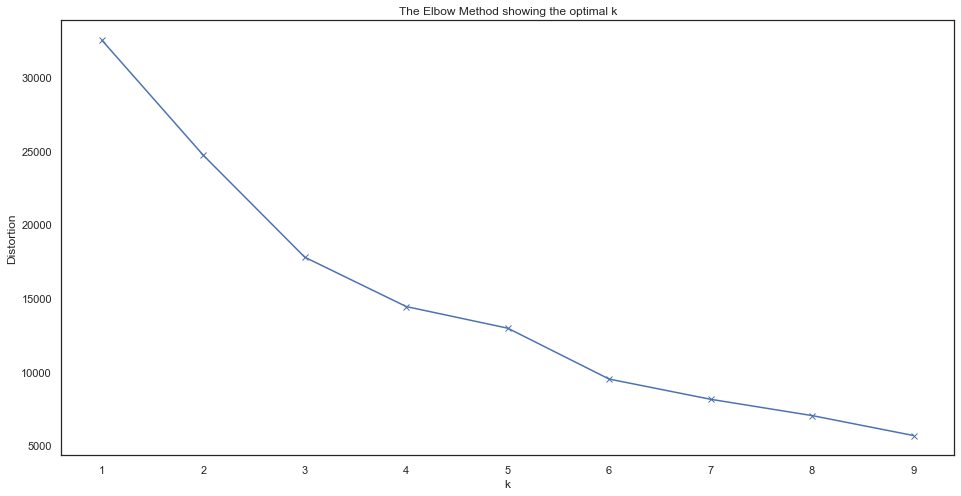

In [64]:
kmeans_clustering_elbow(top_umap_embedded)

In [65]:
global_umap_embedded

array([[ 0.66342676,  1.2264528 ],
       [ 8.438616  ,  3.7310631 ],
       [ 4.0406036 ,  5.8600593 ],
       ...,
       [ 0.889347  ,  6.0330343 ],
       [ 0.06693205,  4.693454  ],
       [14.052707  ,  5.5367494 ]], dtype=float32)

In [66]:
global_kmeans_model = KMeans(n_clusters=3).fit(global_umap_embedded)
y_umap_global_soloq_values['kmeans'] = global_kmeans_model.predict(global_umap_embedded)

In [67]:
y_umap_global_soloq_values

,championName,kmeans
0,Gnar,0
1,Kindred,1
2,Kassadin,0
3,Jhin,0
4,Bard,1
...,...,...
166542,Karma,0
166543,Graves,2
166544,Sylas,0
166545,Chogath,0


In [68]:
#############################################################
##################### UMAP + K-Means ########################
#############################################################
def umap_kmeans(df, n_components = 2, n_neighbors = 15, n_clusters = 3):
    features = [
        "gameDuration", "win",
        "neutralMinionsKilled", "totalMinionsKilled", "cs_diff_at_15",
        "champExperience", "xp_diff", "xp_diff_per_min", "xp_per_min_3_15",
        "damageDealtToBuildings", "damageDealtToObjectives", "damageDealtToTurrets", "damageSelfMitigated", "magicDamageDealt", "magicDamageDealtToChampions", "magicDamageTaken",
        "physicalDamageDealt", "physicalDamageDealtToChampions", "physicalDamageTaken", "totalDamageDealt", "totalDamageDealtToChampions", "totalDamageShieldedOnTeammates",
        "totalDamageTaken", "totalHeal", "totalHealsOnTeammates", "totalUnitsHealed", "trueDamageDealt", "trueDamageDealtToChampions", "trueDamageTaken",
        "totalTimeCCDealt", "timeCCingOthers", "totalTimeSpentDead", "dmg_per_minute_diff", "dmg_per_minute_diff_15", "kills", "deaths", "assists", "kill_share", "kill_participation",
        "doubleKills", "tripleKills", "quadraKills", "pentaKills", "firstBloodAssist", "firstBloodKill", "killingSprees", "largestKillingSpree", "largestMultiKill",
        "goldEarned", "goldSpent", "gold_share", "gold_earned_per_min", "gold_diff_15", "gold_10k_time",
        "inhibitorKills", "inhibitorTakedowns", "inhibitorsLost", 
        "itemsPurchased", "consumablesPurchased",
        "largestCriticalStrike", "longestTimeSpentLiving",
        "firstTowerAssist", "firstTowerKill", "objectivesStolen", "objectivesStolenAssists", "turretKills", "turretTakedowns", "turretsLost",
        "sightWardsBoughtInGame", "visionScore", "visionWardsBoughtInGame", "detectorWardsPlaced", "wardsKilled", "wardsPlaced",
        "spell1Casts", "spell2Casts", "spell3Casts", "spell4Casts", "summoner1Casts", "summoner2Casts",
        "lane_proximity", "jungle_proximity", "percent_mid_lane", "percent_side_lanes", "forward_percentage", "counter_jungle_time_percentage",
    ]
    # standarize
    scaler = StandardScaler()
    x_soloq_values = df.loc[:, features].values
    y_soloq_values = df.loc[:,['championName']]
    x = StandardScaler().fit_transform(x_soloq_values)
    # umap
    umap_reducer = umap.UMAP(n_components= n_components , n_neighbors = n_neighbors, init='random', random_state=0)
    umap_embedded = umap_reducer.fit_transform(x)
    # k-means
    kmeans_model = KMeans(n_clusters= n_clusters ).fit(umap_embedded)
    y_soloq_values['kmeans'] = kmeans_model.predict(umap_embedded)
    
    
    return umap_embedded, y_soloq_values

In [69]:
global_umap_embedded, y_umap_global_soloq_values = umap_kmeans(global_soloq, n_components = 2, n_neighbors = 15, n_clusters = 6)
y_umap_global_soloq_values

,championName,kmeans
0,Gnar,4
1,Kindred,5
2,Kassadin,2
3,Jhin,0
4,Bard,1
...,...,...
166542,Karma,4
166543,Graves,3
166544,Sylas,2
166545,Chogath,2


In [70]:
pd.unique(y_umap_global_soloq_values['kmeans'])

array([4, 5, 2, 0, 1, 3])

In [71]:
class_1 = y_umap_global_soloq_values[y_umap_global_soloq_values['kmeans'] == 0]
class_2 = y_umap_global_soloq_values[y_umap_global_soloq_values['kmeans'] == 1]
class_3 = y_umap_global_soloq_values[y_umap_global_soloq_values['kmeans'] == 2]
pd.unique(class_3['championName'])

array(['Kassadin', 'Kennen', 'Akali', 'Zilean', 'Seraphine', 'Corki',
       'Ahri', 'Cassiopeia', 'Rumble', 'Sylas', 'Sett', 'Zoe', 'Karthus',
       'Leblanc', 'Gragas', 'Katarina', 'Vex', 'Orianna', 'Lux', 'Ryze',
       'Syndra', 'Viktor', 'TwistedFate', 'Ziggs', 'Kaisa', 'Malphite',
       'Kayle', 'Chogath', 'Singed', 'Vladimir', 'Karma', 'Ekko', 'Ornn',
       'Azir', 'Tristana', 'Shyvana', 'Fizz', 'Diana', 'Veigar', 'Kayn',
       'Qiyana', 'Akshan', 'Yone', 'Galio', 'Shen', 'Nunu', 'Xerath',
       'Darius', 'Yasuo', 'Xayah', 'Lucian', 'Anivia', 'Talon',
       'AurelionSol', 'Irelia', 'Aatrox', 'Morgana', 'Taliyah', 'Velkoz',
       'Ivern', 'MissFortune', 'Brand', 'Gnar', 'Bard', 'Twitch', 'Lulu',
       'Viego', 'Graves', 'Zed', 'Neeko', 'Sion', 'Nidalee', 'Renekton',
       'Warwick', 'Pyke', 'Ezreal', 'Caitlyn', 'Ashe', 'Riven', 'Zac',
       'Gwen', 'Nautilus', 'Poppy', 'Volibear', 'Jinx', 'Pantheon',
       'TahmKench', 'KogMaw', 'Vayne', 'Garen', 'LeeSin', 'Nocturne',


## Top Lane

In [72]:
top_umap_embedded, y_umap_top_soloq_values = umap_kmeans(top_sampled_soloq, n_components = 2, n_neighbors = 15, n_clusters = 6)
y_umap_top_soloq_values

,championName,kmeans
0,Aatrox,1
1,Aatrox,5
2,Aatrox,5
3,Aatrox,5
4,Aatrox,5
...,...,...
3595,Yone,5
3596,Yone,0
3597,Yone,0
3598,Yone,5


In [73]:
pd.unique(y_umap_top_soloq_values['kmeans'])

array([1, 5, 0, 2, 3, 4])

In [74]:
top_class_1 = y_umap_top_soloq_values[y_umap_top_soloq_values['kmeans'] == 0]
top_class_2 = y_umap_top_soloq_values[y_umap_top_soloq_values['kmeans'] == 1]
top_class_3 = y_umap_top_soloq_values[y_umap_top_soloq_values['kmeans'] == 2]
top_class_4 = y_umap_top_soloq_values[y_umap_top_soloq_values['kmeans'] == 3]
top_class_5 = y_umap_top_soloq_values[y_umap_top_soloq_values['kmeans'] == 4]
top_class_6 = y_umap_top_soloq_values[y_umap_top_soloq_values['kmeans'] == 5]
pd.unique(top_class_1['championName'])

array(['Aatrox', 'Akali', 'Akshan', 'Camille', 'Darius', 'Fiora',
       'Gangplank', 'Garen', 'Gnar', 'Graves', 'Gwen', 'Illaoi', 'Irelia',
       'Jax', 'Kayle', 'Kennen', 'Lucian', 'Malphite', 'Ornn', 'Pantheon',
       'Poppy', 'Renekton', 'Riven', 'Sett', 'Shen', 'Sion', 'Tryndamere',
       'Urgot', 'Vayne', 'Volibear', 'Yasuo', 'Yone'], dtype=object)

In [75]:
print("class 1")
for x in pd.unique(top_class_1['championName']):
    print(x)
print("")
print("")
    
print("class 2")
for x in pd.unique(top_class_2['championName']):
    print(x)
print("")
print("")

print("class 3")
for x in pd.unique(top_class_3['championName']):
    print(x)
print("")
print("")

print("class 4")
for x in pd.unique(top_class_4['championName']):
    print(x)
print("")
print("")

print("class 5")
for x in pd.unique(top_class_5['championName']):
    print(x)
print("")
print("")

print("class 6")
for x in pd.unique(top_class_6['championName']):
    print(x)
print("")
print("")

class 1
Aatrox
Akali
Akshan
Camille
Darius
Fiora
Gangplank
Garen
Gnar
Graves
Gwen
Illaoi
Irelia
Jax
Kayle
Kennen
Lucian
Malphite
Ornn
Pantheon
Poppy
Renekton
Riven
Sett
Shen
Sion
Tryndamere
Urgot
Vayne
Volibear
Yasuo
Yone


class 2
Aatrox
Akali
Akshan
Camille
Darius
Fiora
Gangplank
Garen
Gnar
Gragas
Graves
Gwen
Illaoi
Irelia
Jax
Jayce
Karma
Kayle
Kennen
Lucian
Malphite
Ornn
Pantheon
Poppy
Renekton
Riven
Rumble
Sett
Shen
Sion
Tryndamere
Urgot
Vayne
Volibear
Yasuo
Yone


class 3
Aatrox
Akali
Akshan
Camille
Darius
Gangplank
Garen
Gnar
Gragas
Graves
Gwen
Illaoi
Irelia
Jax
Jayce
Kayle
Kennen
Lucian
Malphite
Ornn
Pantheon
Poppy
Renekton
Riven
Rumble
Shen
Tryndamere
Urgot
Vayne
Yone


class 4
Aatrox
Akali
Akshan
Camille
Darius
Fiora
Gangplank
Gnar
Gragas
Graves
Gwen
Irelia
Karma
Kayle
Kennen
Malphite
Ornn
Pantheon
Poppy
Renekton
Riven
Rumble
Sett
Shen
Sion
Urgot
Vayne
Volibear
Yasuo


class 5
Akali
Akshan
Camille
Gangplank
Gnar
Gragas
Graves
Gwen
Jax
Jayce
Karma
Lucian
Ornn
Tryndamere
Volibea